# 20260128: 實作NCSN+Annealing Langevin Sampling - 2D

1. 建構 NCSN (Model)：寫一個神經網路，輸入是 $(x, \sigma)$，輸出是 $\epsilon$ (或 Score)。 定義 Loss Function 來訓練它。
2. 實作 Algorithm 1 (Sampling)：寫一個函式，裡面有兩層迴圈。外層控制 $\sigma$ (Annealing)。內層跑 $T$ 次演算法中第 6 行的公式 (Langevin Step)。



## Model
根據 NCSN 的目標函數定義，原始的 Denoising Score Matching 損失函數為：$$\ell(\theta; \sigma) \triangleq \frac{1}{2} \mathbb{E}_{p_{\text{data}}(x)} \mathbb{E}_{\tilde{x} \sim \mathcal{N}(x, \sigma^2 I)} \left[ \left\| s_\theta(\tilde{x}, \sigma) + \frac{\tilde{x} - x}{\sigma^2} \right\|_2^2 \right]$$

其中總損失函數定義為 $$\mathcal{L} = \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) \ell(\theta; \sigma_i).$$

為了數值穩定性，NCSN 選擇權重函數 $\lambda(\sigma_i) = \sigma_i^2$。

實作方面，我們定義一個噪聲預測網路 $\boldsymbol{\epsilon}_\theta(\tilde{x}, \sigma)$，並令：$$s_\theta(\tilde{x}, \sigma) \triangleq -\frac{\boldsymbol{\epsilon}_\theta(\tilde{x}, \sigma)}{\sigma}$$

## Langevin
在演算法中(第6行):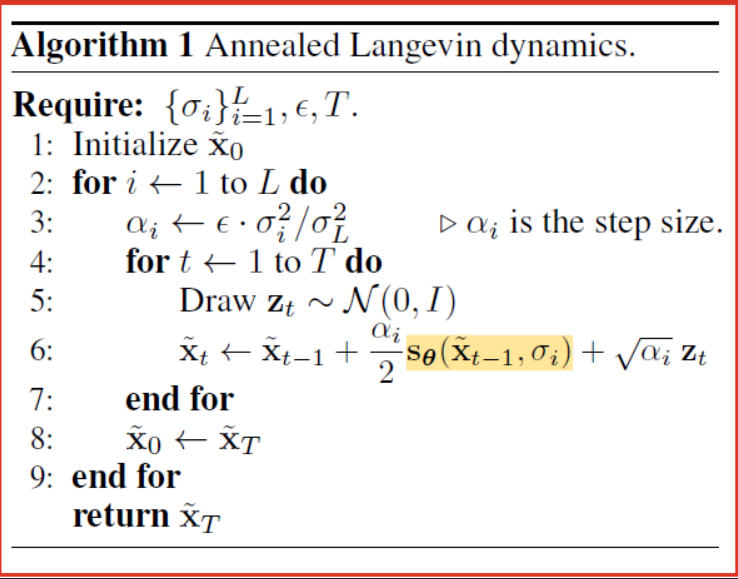
* 原版 (預測 Score):$$\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} \mathbf{s_\theta}(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$$
* 新版 (預測 $\epsilon$):因為 $\text{Score} \approx -\frac{\epsilon}{\sigma}$，所以把 $s_\theta$ 換掉：$$\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} \left( -\frac{\boldsymbol{\epsilon}_\theta(\tilde{x}_{t-1}, \sigma_i)}{\sigma_i} \right) + \sqrt{\alpha_i} z_t$$

---

# Model

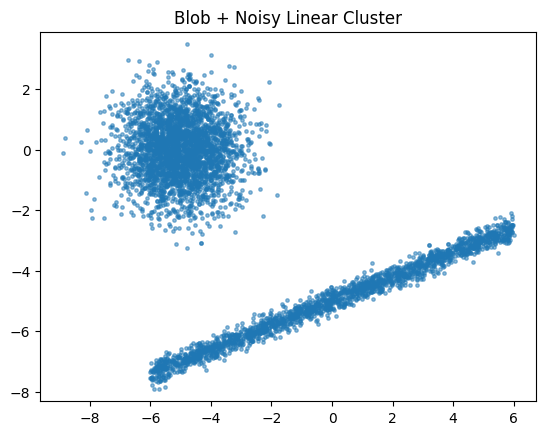

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

batch_size=2048

#=========== Sample
def sample_line(n_points):
    slope = 0.4
    intercept = -5.0
    
    x = np.random.uniform(-6, 6, size=n_points)
    noise = np.random.randn(n_points) * 0.2   
    y = slope * x + intercept + noise

    return np.stack([x, y], axis=1)

def sample_blob(n_points):
    mu = np.array([-5, 0])
    C = np.eye(2) * 1.0
    return mu + np.random.multivariate_normal([0,0], C, size=n_points)

def sample_p0_mix(n_blob=3000, n_line=2000):
    blob = sample_blob(n_blob)
    line = sample_line(n_line)

    data = np.concatenate([blob, line], axis=0)
    np.random.shuffle(data)
    return data

#=============== Plot sample
data = sample_p0_mix()

plt.scatter(data[:,0], data[:,1], s=6, alpha=0.5)
plt.axis('equal')
plt.title("Blob + Noisy Linear Cluster")
plt.show()


In [9]:
class NCSN_2D(nn.Module):
    def __init__(self, x_dim, hidden, num_layers, num_classes):
        super().__init__()
        
        self.embed = nn.Embedding(num_classes, hidden) 
        self.fc1 = nn.Linear(x_dim, hidden)
        self.layers = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden, hidden))
        self.fc_out = nn.Linear(hidden, x_dim)
        self.act = nn.SiLU() # 或 nn.Softplus()

    def forward(self, x, labels):
        # 1. 處理輸入
        h = self.fc1(x)
        
        # 2. 加入 sigma 的資訊 (Embedding)
        # 將 label embedding 加到第一層輸出的特徵上 (Conditioning)
        embed = self.embed(labels)
        h = h + embed 
        h = self.act(h)
        
        # 3. 後續層
        for layer in self.layers:
            h = self.act(layer(h))
            
        out = self.fc_out(h)
        
        # 4. 輸出正規化 (NCSN 建議輸出 score = -epsilon / sigma)
        # 這裡我們預測 epsilon，所以後續計算 loss 或 sampling 時要注意除以 sigma
        return out


In [10]:
num_classes=10
sigmas = torch.tensor(
    np.exp(np.linspace(np.log(50), np.log(0.01), 10)),
    dtype=torch.float32
).to(device)

model = NCSN_2D(x_dim=2, hidden=128, num_layers=3, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)

# --- Loss Step ---
def annealed_dsm_loss(model, batch_size):
    n_blob = batch_size // 2
    n_line = batch_size - n_blob
    x0_np = sample_p0_mix(n_blob, n_line).astype(np.float32)
    x0 = torch.from_numpy(x0_np).to(device)
    
    labels = torch.randint(0, num_classes, (batch_size,), device=device)
    used_sigmas = sigmas[labels].view(batch_size, 1) # [batch, 1]
    noise = torch.randn_like(x0)
    x_tilde = x0 + used_sigmas * noise
    
    eps_pred = model(x_tilde, labels)
    
    loss = ((eps_pred - noise) ** 2).mean()
    return loss

# --- Training ---
print("Start Training...")
n_step=5000
loss_history = []
for epoch in range(1,n_step+1):
    model.train()
    loss = annealed_dsm_loss(model, batch_size)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Start Training...
Epoch  200 | Loss: 0.586864
Epoch  400 | Loss: 0.598738
Epoch  600 | Loss: 0.566692
Epoch  800 | Loss: 0.565502
Epoch 1000 | Loss: 0.597572
Epoch 1200 | Loss: 0.559217
Epoch 1400 | Loss: 0.571100
Epoch 1600 | Loss: 0.579666
Epoch 1800 | Loss: 0.517058
Epoch 2000 | Loss: 0.580779
Epoch 2200 | Loss: 0.556237
Epoch 2400 | Loss: 0.595829
Epoch 2600 | Loss: 0.578074
Epoch 2800 | Loss: 0.569243
Epoch 3000 | Loss: 0.563757
Epoch 3200 | Loss: 0.597296
Epoch 3400 | Loss: 0.545210
Epoch 3600 | Loss: 0.578375
Epoch 3800 | Loss: 0.579530
Epoch 4000 | Loss: 0.569904
Epoch 4200 | Loss: 0.569904
Epoch 4400 | Loss: 0.551163
Epoch 4600 | Loss: 0.590660
Epoch 4800 | Loss: 0.555510
Epoch 5000 | Loss: 0.553206


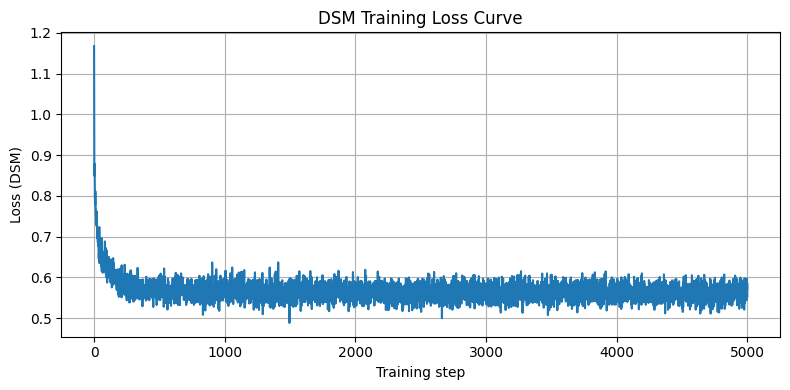

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# Annealed Langevin

In [18]:
@torch.no_grad()
def annealed_langevin_sampling(model, n_samples=1000, n_steps_each=100, step_lr=0.00002):
    model.eval()
    
    x = torch.rand(n_samples, 2).to(device) * 12 - 6     
    traj = [x.cpu().numpy().copy()] 
    
    for i, sigma in enumerate(sigmas):
        # alpha_i = epsilon * (sigma_i / sigma_L)^2
        alpha = step_lr * (sigma / sigmas[-1]) ** 2
        
        labels = torch.ones(n_samples, dtype=torch.long).to(device) * i
        
        for t in range(n_steps_each):
            # 預測 noise (epsilon)
            eps_pred = model(x, labels)
            
            # score = -epsilon / sigma
            score = -eps_pred / sigma
            
            # Langevin Update
            # x_{t+1} = x_t + (alpha/2) * score + sqrt(alpha) * z
            z = torch.randn_like(x)
            x = x + (alpha / 2) * score + torch.sqrt(alpha) * z
            
        traj.append(x.cpu().numpy().copy())
        
    return x.cpu().numpy(), traj



## Sample 1: 正常

In [ ]:
# --- Sampling ---
final_samples, trajectory = annealed_langevin_sampling(
    model, 
    n_samples=2000, 
    n_steps_each=100, # 每個 sigma 走幾步
    step_lr=0.00002   # 步長係數，太大的話會發散
)

plt.figure(figsize=(12, 4))

# Ground Truth
plt.subplot(1, 3, 1)
data_gt = sample_p0_mix(1000, 1000)
plt.scatter(data_gt[:, 0], data_gt[:, 1], s=2, alpha=0.5, c='black')
plt.title("Ground Truth")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

# 初始噪聲 (第一層 sigmas[0] 的狀態，如果有的話)
plt.subplot(1, 3, 2)
plt.scatter(trajectory[0][:, 0], trajectory[0][:, 1], s=2, alpha=0.5, c='gray')
plt.title("Initialization")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

# 生成結果
plt.subplot(1, 3, 3)
plt.scatter(final_samples[:, 0], final_samples[:, 1], s=2, alpha=0.5, c='purple')
plt.title("Generated (Annealed Langevin)")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

## Sample 2: step_lr=5e-10 (結果:發散無法移動)

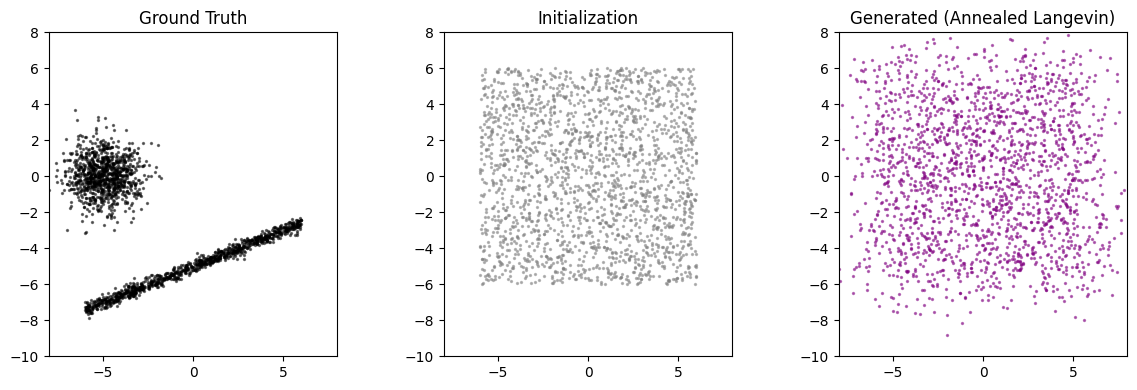

In [30]:
# --- Sampling ---
final_samples, trajectory = annealed_langevin_sampling(
    model, 
    n_samples=2000, 
    n_steps_each=100, # 每個 sigma 走幾步
    step_lr=5e-10   # 步長係數，太大的話會發散
)

plt.figure(figsize=(12, 4))

# Ground Truth
plt.subplot(1, 3, 1)
data_gt = sample_p0_mix(1000, 1000)
plt.scatter(data_gt[:, 0], data_gt[:, 1], s=2, alpha=0.5, c='black')
plt.title("Ground Truth")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

# 初始噪聲 (第一層 sigmas[0] 的狀態，如果有的話)
plt.subplot(1, 3, 2)
plt.scatter(trajectory[0][:, 0], trajectory[0][:, 1], s=2, alpha=0.5, c='gray')
plt.title("Initialization")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

# 生成結果
plt.subplot(1, 3, 3)
plt.scatter(final_samples[:, 0], final_samples[:, 1], s=2, alpha=0.5, c='purple')
plt.title("Generated (Annealed Langevin)")
plt.xlim(-8, 8); plt.ylim(-10, 8)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()